In [1]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import mine_emis
import utils

In [2]:
""" 
Data Sources

GEMS_GCMT_FILE: 
https://globalenergymonitor.org/projects/global-coal-mine-tracker/

MSHA_PRODUCTION_FILE: 
https://www.msha.gov/data-and-reports/mine-data-retrieval-system
"Employment Production Dataset (Quarterly)"

EPA Gas Content By Basin: 
Inventory of U.S. Greenhouse Gas Emissions and Sinks: 1990–2022
ANNEX 3 Methodological Descriptions for Additional Source or Sink Categories
"""
GEMS_GCMT_FILE = "../data/Global-Coal-Mine-Tracker-April-2024.xlsx"
MSHA_PRODUCTION_FILE = "../data/MinesProdQuarterly.txt"
EPA_BASIN_LUT = '../data/EPA_basin_definitions_A-96.csv'
LONGWALL_CENSUS = '../data/longwall_census.csv'
LOOKUP_TABLE = '../data/facility_lookup.csv'

CM_EF_FILE = '../data/CM_basin_EFs.csv'
CM_WELL_EF_FILE = '../data/CM_well_EFs.csv'
EPA_EF_FILE = '../data/EPA_Basin_EFs.csv'

DIAMOND_GAS_CONTENT = "../data/diamond_table_by_basin/diamond_table.csv"

# M3_TO_KG = 0.6802 # https://www.epa.gov/cmop/updated-coal-mine-methane-units-converter 
# KG_TO_M_T = 1e-3 * 1e-6 # kg to million metric tons 
# MST_TO_T = 0.907185 * 1e6 # Million short tons to metric tons 
# FT3_PER_SHORT_TON_TO_M3_PER_TON = (0.3048)**3 / 0.907185
# FT_TO_M = 0.3048
# T_TO_M_T = 1e-6

M3_TO_KG = utils.M3_TO_KG # https://www.epa.gov/cmop/updated-coal-mine-methane-units-converter 
KG_TO_M_T = utils.KG_TO_M_T # kg to million metric tons 
MST_TO_T = utils.MST_TO_T # Million short tons to metric tons 
FT3_PER_SHORT_TON_TO_M3_PER_TON = utils.FT3_PER_SHORT_TON_TO_M3_PER_TON
FT_TO_M = utils.FT_TO_M
T_TO_M_T = utils.T_TO_M_T

# Citation numbers. Update these if order of citations changes in a later draft!!
KHOLOD2020 = '16'
DIAMOND1986 = '38'
EPA2024 = '8'
UNECE2022 = '40'

basin_names_replacement = {
    'Central Appalachian Basin': 'central Appalachian Basin',
    'Illinois Basin': 'Illinois Basin',
    'North Great Plains Basin': 'Northern Great Plains',
    'Northern Appalachian Basin': 'northern Appalachian Basin',
    'Southwest and Rockies Basin': 'Colorado Plateau',
    'Warrior Basin': 'Black Warrior Basin',}


In [3]:
def generate_IPCC_EFs(df, depth_col="Mine Depth (m)", suffix=""):  
    IPCC_col = "IPCC_EF"+suffix
    df[IPCC_col] = np.nan
    df.loc[df[depth_col] < 200., IPCC_col] = 10.
    df.loc[(df[depth_col] >= 200.) & (df[depth_col] < 400.), IPCC_col] = 18.
    df.loc[df[depth_col] >= 400., IPCC_col] = 25.
    return df

def generate_MC2M_EFs(df, depth_col="Mine Depth (m)", type_col="Coal Type", suffix=""):
    # MC2M
    # Table S9 Page 9/10 of Kholod et al. 
    gas_col, kholod_EF_col, gem_EF_col = "MC2M_gas_content"+suffix, "Kholod_EF"+suffix, "GEM_EF"+suffix
    df.drop(columns=["V_L", "P_L", gas_col, kholod_EF_col, gem_EF_col], errors="ignore", inplace=True) # drop these in order to re-calcualte them
    VL_df = pd.DataFrame({type_col: ['Anthracite', 'Bituminous', 'Subbituminous'], 'V_L': [33.6, 23.2, 9.8]}) # Langmuir volume
    PL_df = pd.DataFrame({type_col: ['Anthracite', 'Bituminous', 'Subbituminous'], 'P_L': [1.9, 3.3, 5.7]}) # Langmuir pressure
    df = pd.merge(df, VL_df, on=type_col, how="left")
    df = pd.merge(df, PL_df, on=type_col, how="left")
    L = 0.00980665 # Langmuir constant 
    df[gas_col] = df.V_L * df[depth_col] * L / (df.P_L + df[depth_col] * L) 
    df[kholod_EF_col] = 1.9 * df[gas_col] # C_EF = 1.9
    df[gem_EF_col] = 1.6 * df[gas_col] # C_EF = 1.6
    return df

def generate_basin_EFs(df, 
                       gas_content_col = "Underground Average In Situ Content (ft3/short ton)", 
                       unit_conversion = FT3_PER_SHORT_TON_TO_M3_PER_TON):
    df['Basin_EF'] = 1.9 * df[gas_content_col] * unit_conversion
    return df

In [4]:
gems = pd.read_excel(GEMS_GCMT_FILE, sheet_name="Global Coal Mine Tracker (Non-C")
gems2 = pd.read_excel(GEMS_GCMT_FILE, sheet_name="Global Coal Mine Tracker (Close")
gems = pd.concat([gems,gems2])
gems["MSHA ID"] = gems["MSHA ID"].astype(str).str.replace('.0','', regex=False)
gems = gems[gems['GEM Coal Mine Methane Emissions Estimate (MCM/yr)']!='-']

prod = pd.read_csv(MSHA_PRODUCTION_FILE, sep="|", encoding="latin1") # Units: Tonnes
prod = prod[(prod["CAL_YR"].isin([2022])) & (prod["SUBUNIT"]=="UNDERGROUND") & (prod['COAL_METAL_IND']=='C')]
prod["MINE_ID"] = prod["MINE_ID"].astype(str)

longwall_data = pd.read_csv(LONGWALL_CENSUS)
columns_with_range = ['Seam Height (inches)', 'Cutting Height (inches)', 'Panel Width (ft)', 'Panel Length (ft)', 'Overburden']
longwall_data[columns_with_range] = longwall_data[columns_with_range].applymap(lambda x: np.mean(np.array(x.split('-')).astype(float)))
longwall_data['Overburden'] = longwall_data['Overburden'] * FT_TO_M
longwall_data['MSHA ID'] = longwall_data['MSHA ID'].astype(str).replace('.0','', regex=False)
longwall_data = longwall_data.drop_duplicates(subset='MSHA ID') # lazy way to deduplicate
longwall_data['supercritical'] = ((longwall_data['Panel Width (ft)'] / longwall_data['Overburden']) > 1.2).astype(int)

lut = pd.read_csv(LOOKUP_TABLE)
lut['msha_identification_number'] = lut['msha_identification_number'].astype(str).str.replace('.0', '', regex=False)
lut['facility_id'] = lut['facility_id'].astype(str).str.replace('.0', '', regex=False)
lut = lut[~lut.facility_id.isin(['1005297'])] # Drop Prep plant for road fork 42, because it duplicates facility_id

epa_summary = mine_emis.ghgrp()[['facility_id', 'reporting_year', 'quarter', 'number_of_wells']]
epa_summary = pd.merge(epa_summary, lut[['facility_id', 'msha_identification_number']], on='facility_id', how='left')

basin_gas_content = pd.read_csv(EPA_BASIN_LUT)
# These states have two basins. Gas contents for both basins in these states are very  similar, so just drop the smaller basin. 
basin_gas_content = basin_gas_content[~(basin_gas_content['State']=='Kentucky (west)')]
basin_gas_content = basin_gas_content[~(basin_gas_content['State']=='West Virginia (South)')]

cm_fitted_EFs = pd.read_csv(CM_EF_FILE).rename(columns={'slope': 'CM_EF'})
cm_min_EFs = pd.read_csv(CM_EF_FILE).rename(columns={'min_slope': 'CM_min_EF'})
cm_max_EFs = pd.read_csv(CM_EF_FILE).rename(columns={'max_slope': 'CM_max_EF'})
cm_well_EFs = pd.read_csv(CM_WELL_EF_FILE).rename(columns={'slope': 'CM_well_EF'})
cm_well_min_EFs = pd.read_csv(CM_WELL_EF_FILE).rename(columns={'min_slope': 'CM_well_min_EF'})
cm_well_max_EFs = pd.read_csv(CM_WELL_EF_FILE).rename(columns={'max_slope': 'CM_well_max_EF'})
epa_fitted_EFs = pd.read_csv(EPA_EF_FILE).rename(columns={'slope': 'EPA_EF'})

df = pd.merge(prod,
              gems[["MSHA ID", 
                    "Coal Type", 
                    "Coal Grade", 
                    "Mine Name", 
                    "Mine Type", 
                    "Mine Depth (m)", 
                    "Coal Output (Annual, Mst)",
                    "GEM Coal Mine Methane Emissions Estimate (M tonnes/yr)"]], 
                    left_on="MINE_ID", right_on="MSHA ID", how="left")
df = pd.merge(df, basin_gas_content, left_on='STATE', right_on='ST', how='left')
df = pd.merge(df, longwall_data, left_on='MINE_ID', right_on='MSHA ID', how='left')

# Fill mines with no Longwall Data
additional_supercritical_mines = ("San Juan Mine 1", "Beckley Pocahontas Coal Mine", "Heilwood Coal Mine", "Lowry Coal Mine")
df.loc[df['Mine Name'].isin(additional_supercritical_mines), 'supercritical'] = 1
df['Basin_Critical'] = ''
df.loc[df.supercritical.notnull(),'Basin_Critical'] =(df['Basin'] + ' ' + df['supercritical'
                                                                             ].astype(str)).str.replace('.0','',regex=False
                                                                                                        ).str.replace('1', 'Supercritical'
                                                                                                        ).str.replace('0', 'Subcritical')

df = pd.merge(df, cm_fitted_EFs[['Basin', 'CM_EF']], on='Basin', how='left')
df = pd.merge(df, cm_min_EFs[['Basin', 'CM_min_EF']], on='Basin', how='left')
df = pd.merge(df, cm_max_EFs[['Basin', 'CM_max_EF']], on='Basin', how='left')
df = pd.merge(df, cm_well_EFs[['Basin_Critical', 'CM_well_EF']], on='Basin_Critical', how='left')
df = pd.merge(df, cm_well_min_EFs[['Basin_Critical', 'CM_well_min_EF']], on='Basin_Critical', how='left')
df = pd.merge(df, cm_well_max_EFs[['Basin_Critical', 'CM_well_max_EF']], on='Basin_Critical', how='left')
df = pd.merge(df, epa_fitted_EFs[['Basin', 'EPA_EF']], on='Basin', how='left')
df = pd.merge(df, epa_summary, 
              left_on = ["MINE_ID", "CAL_YR", "CAL_QTR"],
              right_on = ["msha_identification_number", "reporting_year", "quarter"], how="left")

# Data cleaning
df.loc[df['MINE_ID']=='4407401', 'Coal Type'] = 'Bituminous' # this mine is bituminous (Source: MSHA database)
df.loc[df.number_of_wells<1.,["CM_well_EF", "CM_well_min_EF", "CM_well_max_EF"]] = 0. # set well_EFs to 0 if there are no wells
df = df.drop('facility_id',axis='columns') # don't need facility_id now we used it for the join. 
print("Why are so many mines missing now??")
# df.loc[df['Mine Depth (m)'].isnull(),"Mine Depth (m)"] = 373. # fill average mine depth for mines missing from GEMS
df.loc[df['Coal Type'].isnull(),"Coal Type"] = "Bituminous" # assume bituminous for mines missing from GEMS

# Only major mystery left is Elk Creek Mine.
df[df['Coal Type']=='-']

Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: BAILEY MINE-CRABAPPLE PORTAL
Fixing number of shafts in: ENLOW FORK MINE
Fixing number of shafts in: HARVEY MINE
Fixing number of shafts in: HARRISON COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: LEER SOUTH MINING COMPLEX
Why are so many mines missing now??


,MINE_ID,CURR_MINE_NM,STATE,SUBUNIT_CD,SUBUNIT,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,AVG_EMPLOYEE_CNT,...,CM_min_EF,CM_max_EF,CM_well_EF,CM_well_min_EF,CM_well_max_EF,EPA_EF,reporting_year,quarter,number_of_wells,msha_identification_number


In [5]:
df = generate_IPCC_EFs(df, depth_col="Mine Depth (m)", suffix="") # m^3 / ton
df = generate_IPCC_EFs(df, depth_col="Overburden", suffix="_CoalAge") # m^3 / ton

df = generate_MC2M_EFs(df, depth_col="Mine Depth (m)", suffix="") # m^3 / ton
df = generate_MC2M_EFs(df, depth_col="Overburden", suffix="_CoalAge") # m^3 / ton

df = generate_basin_EFs(df) # m^3 / ton 

# CM EFS: (kg/hr) / ton

# sanity check - do we get same emissions as GEMS database?
df['replicate_GEM_emis_M_T'] = df.GEM_EF * df["Coal Output (Annual, Mst)"] * MST_TO_T * M3_TO_KG * KG_TO_M_T

# calculate emissions using MSHA coal production
df['GEM_emis_M_T'] = df.GEM_EF * df["COAL_PRODUCTION"] * M3_TO_KG * KG_TO_M_T
df['Kholod_emis_M_T'] = df.Kholod_EF * df["COAL_PRODUCTION"] * M3_TO_KG * KG_TO_M_T
df['IPCC_emis_M_T'] = df.IPCC_EF * df["COAL_PRODUCTION"] * M3_TO_KG * KG_TO_M_T
df['Basin_emis_M_T'] = df.Basin_EF * df["COAL_PRODUCTION"] * M3_TO_KG * KG_TO_M_T

df['EPA_emis_M_T'] = df.EPA_EF * df["COAL_PRODUCTION"] * T_TO_M_T # T to MegaTons

df['CM_vent_emis_M_T'] = df.CM_EF * df["COAL_PRODUCTION"] * 1 / utils.MT_QRT_TO_KG_HR * T_TO_M_T # kg/hr to MegaTons per Quarter
df['CM_min_emis_M_T'] = df.CM_min_EF * df["COAL_PRODUCTION"] * 1 / utils.MT_QRT_TO_KG_HR * T_TO_M_T # kg/hr to MegaTons per Quarter
df['CM_max_emis_M_T'] = df.CM_max_EF * df["COAL_PRODUCTION"] * 1 / utils.MT_QRT_TO_KG_HR * T_TO_M_T # kg/hr to MegaTons per Quarter

df['CM_well_emis_M_T'] = df.CM_well_EF * df["COAL_PRODUCTION"] * 1 / utils.MT_QRT_TO_KG_HR * T_TO_M_T  # kg/hr to MegaTons per Quarter
df['CM_well_min_emis_M_T'] = df.CM_well_min_EF * df["COAL_PRODUCTION"] * 1 / utils.MT_QRT_TO_KG_HR * T_TO_M_T  # kg/hr to MegaTons per Quarter
df['CM_well_max_emis_M_T'] = df.CM_well_max_EF * df["COAL_PRODUCTION"] * 1 / utils.MT_QRT_TO_KG_HR * T_TO_M_T  # kg/hr to MegaTons per Quarter

df['GEM_emis_CoalAge_M_T'] = df.GEM_EF_CoalAge * df["COAL_PRODUCTION"] * M3_TO_KG * KG_TO_M_T
df['Kholod_emis_CoalAge_M_T'] = df.Kholod_EF_CoalAge * df["COAL_PRODUCTION"] * M3_TO_KG * KG_TO_M_T
df['IPCC_emis_CoalAge_M_T'] = df.IPCC_EF_CoalAge * df["COAL_PRODUCTION"] * M3_TO_KG * KG_TO_M_T

In [6]:
print("total number of mines")
print(df[(df['CAL_YR']==2022)&(df['COAL_PRODUCTION']>0)]['MINE_ID'].nunique())

print("mines reporting to EPA, 2022")
print(epa_summary[epa_summary.reporting_year==2022].facility_id.nunique())

total number of mines
187
mines reporting to EPA, 2022
62


In [7]:
df.to_csv("../data/Inventory_emissions.csv", index=False)

# Make sure you did it right

Text(0, 0.5, 'Our Replicated GEM')

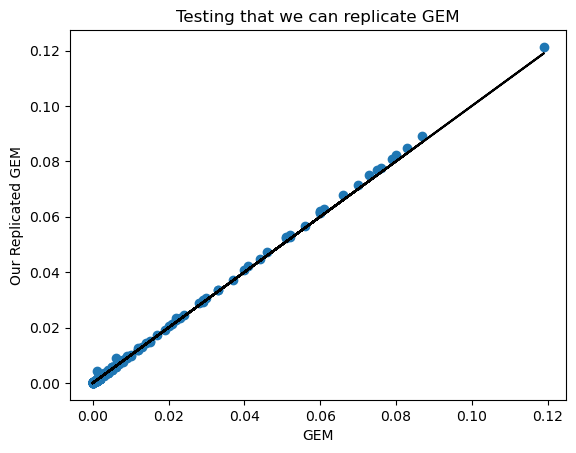

In [8]:
sum_nans = lambda x: x.sum(min_count=4)
annual_df = df.groupby(["Mine Name", "CAL_YR"]).agg({"GEM_emis_M_T": sum_nans, 
                                                 "Kholod_emis_M_T": sum_nans, 
                                                 "IPCC_emis_M_T": sum_nans, 
                                                 "GEM_emis_CoalAge_M_T": sum_nans, 
                                                 "Kholod_emis_CoalAge_M_T": sum_nans, 
                                                 "IPCC_emis_CoalAge_M_T": sum_nans, 
                                                 "Basin_emis_M_T": sum_nans,
                                                 "replicate_GEM_emis_M_T": "mean",
                                                 "GEM Coal Mine Methane Emissions Estimate (M tonnes/yr)": "mean"})

plt.plot(annual_df['GEM Coal Mine Methane Emissions Estimate (M tonnes/yr)'], annual_df['replicate_GEM_emis_M_T'], 'o')
plt.plot(annual_df['GEM Coal Mine Methane Emissions Estimate (M tonnes/yr)'], annual_df['GEM Coal Mine Methane Emissions Estimate (M tonnes/yr)'], 'k')
plt.title("Testing that we can replicate GEM")
plt.xlabel("GEM")
plt.ylabel("Our Replicated GEM")

Text(0, 0.5, 'IPCC emissions')

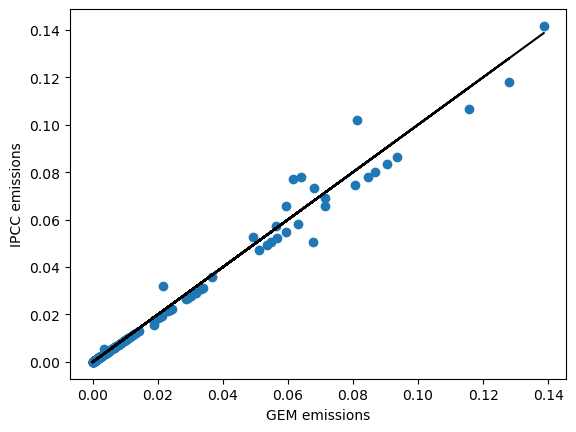

In [9]:
plt.plot(annual_df['GEM_emis_M_T'], annual_df['IPCC_emis_M_T'], 'o')
plt.plot(annual_df['GEM_emis_M_T'], annual_df['GEM_emis_M_T'], 'k')
plt.xlabel("GEM emissions")
plt.ylabel("IPCC emissions")

Text(0, 0.5, 'Basin emissions')

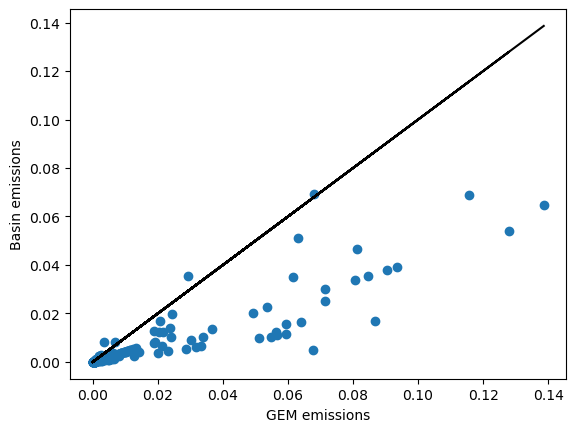

In [10]:
plt.plot(annual_df['GEM_emis_M_T'], annual_df['Basin_emis_M_T'], 'o')
plt.plot(annual_df['GEM_emis_M_T'], annual_df['GEM_emis_M_T'], 'k')
plt.xlabel("GEM emissions") 
plt.ylabel("Basin emissions") 

Text(0, 0.5, 'Kholod emissions with accurate depth')

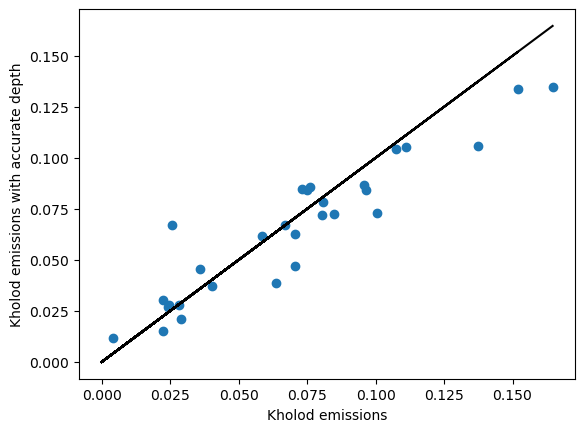

In [11]:
plt.plot(annual_df['Kholod_emis_M_T'], annual_df['Kholod_emis_CoalAge_M_T'], 'o')
plt.plot(annual_df['Kholod_emis_M_T'], annual_df['Kholod_emis_M_T'], 'k')
plt.xlabel("Kholod emissions") 
plt.ylabel("Kholod emissions with accurate depth") 

Text(0, 0.5, 'IPCC emissions with accurate depth')

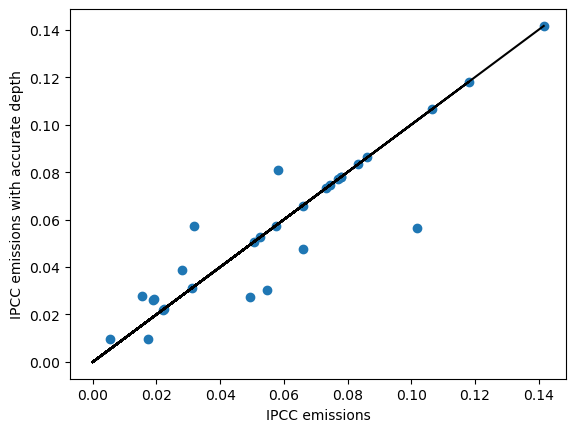

In [12]:
plt.plot(annual_df['IPCC_emis_M_T'], annual_df['IPCC_emis_CoalAge_M_T'], 'o')
plt.plot(annual_df['IPCC_emis_M_T'], annual_df['IPCC_emis_M_T'], 'k')
plt.xlabel("IPCC emissions") 
plt.ylabel("IPCC emissions with accurate depth") 

In [13]:
df[(df.CAL_YR==2023)&(df.COAL_PRODUCTION>0)].groupby('Mine Name').agg(lambda x: x.unique()[0])['Coal Type'].value_counts()

Series([], Name: Coal Type, dtype: int64)

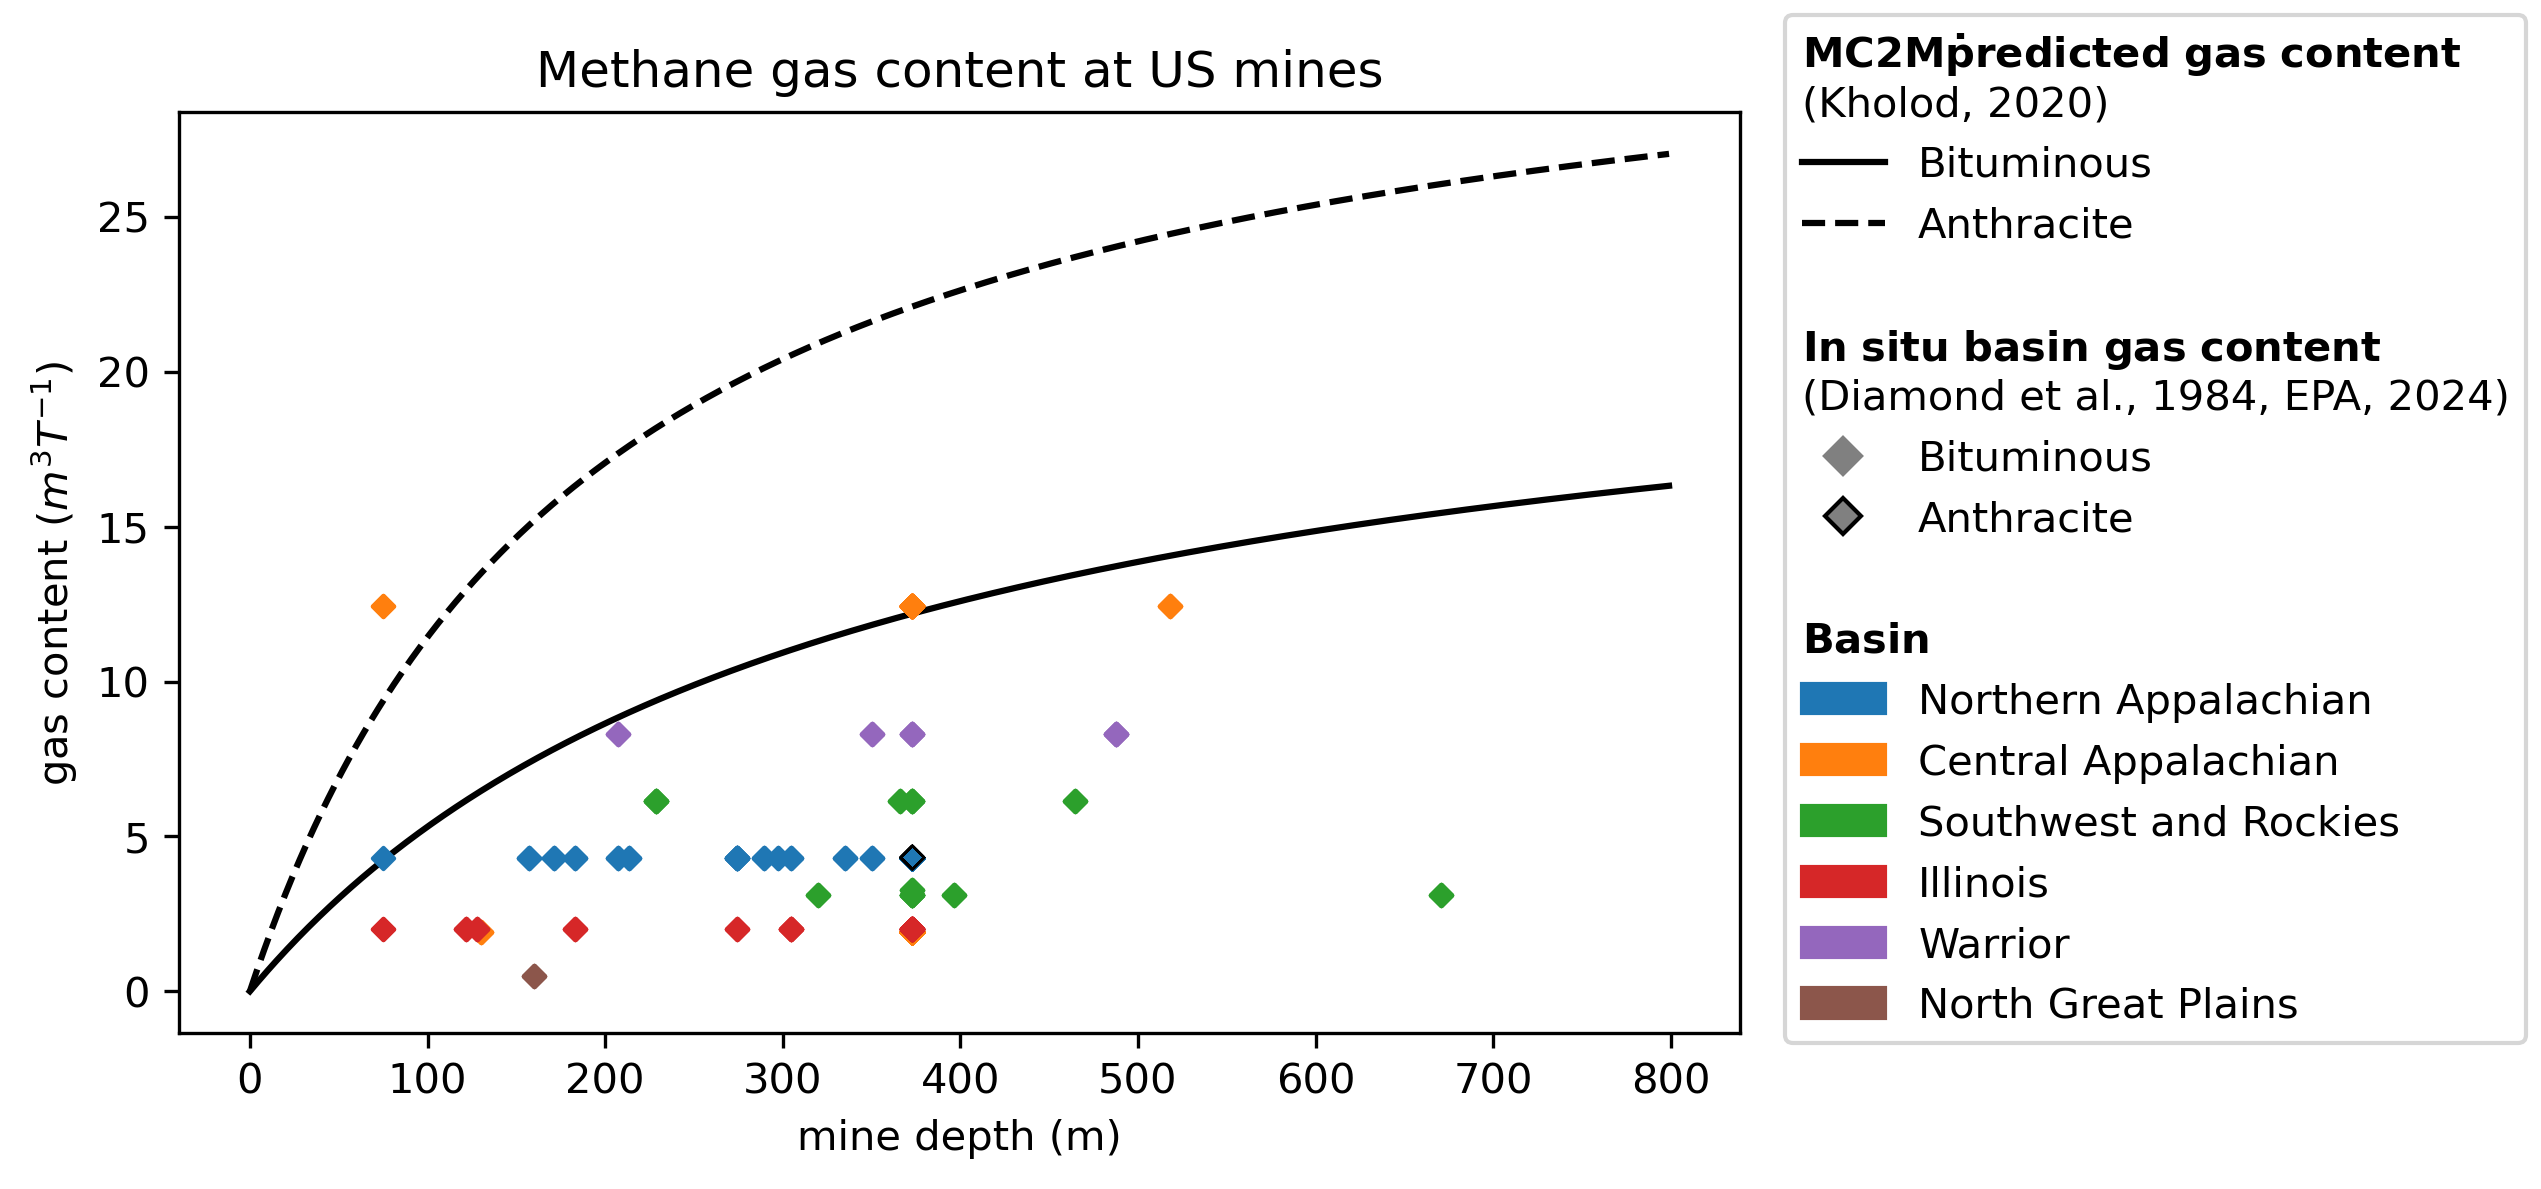

In [14]:
fig = plt.figure(figsize=(6,4), dpi=300)
legend_fontsize = 10
order=[2,0,3,1,4,5] # order of legend

# dummy DF of MC2M
dummy_df = pd.DataFrame()
dummy_df['depth_m'] = np.arange(0,800,1.)
dummy_df['coal_grade'] = 'Bituminous'
dummy_df = generate_MC2M_EFs(dummy_df, depth_col="depth_m", type_col="coal_grade", suffix="")
plt.plot(dummy_df.depth_m, dummy_df.MC2M_gas_content, label="MC2M predicted gas content\n(Kholod, 2020)", color='k', zorder=-1)


# dummy DF of MC2M
dummy_df = pd.DataFrame()
dummy_df['depth_m'] = np.arange(0,800,1.)
dummy_df['coal_grade'] = 'Anthracite'
dummy_df = generate_MC2M_EFs(dummy_df, depth_col="depth_m", type_col="coal_grade", suffix="")
plt.plot(dummy_df.depth_m, dummy_df.MC2M_gas_content, label="MC2M predicted gas content\n(Kholod, 2020)", color='k', linestyle='--', zorder=-1)

# gap fill with GEMs mine depth when overburden is not available
df['combined_mine_depth'] = df['Overburden']
df.loc[df.combined_mine_depth.isnull(),'combined_mine_depth'] = df.loc[df.combined_mine_depth.isnull(),'Mine Depth (m)']
df['combined_mine_depth'].value_counts()

legend_contents3 = []
for basin in df['Basin'].unique()[order]:
    if pd.isnull(basin):
        continue
    subset =df[(df['Basin'] == basin)&(df['Coal Type']=='Bituminous')]
    if subset.empty: continue
    p = plt.scatter(subset.combined_mine_depth, subset["Underground Average In Situ Content (ft3/short ton)"] * FT3_PER_SHORT_TON_TO_M3_PER_TON, 
                    marker="D", s=13, label=basin)
    basin_color = p.get_facecolors()[0]
    legend_contents3.append((Patch(color=basin_color), basin.replace(' Basin','')))
    
    subset =df[(df['Basin'] == basin)&(df['Coal Type']=='Anthracite')]
    if subset.empty: continue
    plt.scatter(subset.combined_mine_depth, subset["Underground Average In Situ Content (ft3/short ton)"] * FT3_PER_SHORT_TON_TO_M3_PER_TON, 
                marker="D", facecolor='none', edgecolor='k', linewidth=0.5, s=16, label=basin, zorder=100)

legend_contents1 = [
    (plt.Line2D([], [], linestyle='-', marker=None, color='k'), "Bituminous"),
    (plt.Line2D([], [], linestyle='--', marker=None, color='k'), "Anthracite"),
    (Patch(visible=False), ''),  # spacer
    ] 

legend_contents2 = [
    (plt.Line2D([], [], linestyle='', marker='D', color='gray'), 'Bituminous'),
    (plt.Line2D([], [], linestyle='', marker='D', markerfacecolor='gray', markeredgecolor='k'), 'Anthracite'),
    (Patch(visible=False), ''),  # spacer
    ] 

def append_legends(legend_list, fig):
    """
    Sources: 
    - https://stackoverflow.com/questions/24787041/multiple-titles-in-legend-in-matplotlib
    - https://github.com/mwaskom/seaborn/blob/v0.12/seaborn/_core/plot.py#L1620-L1640
    """
    base_legend = legend_list[0]
    for legend in legend_list[1:]:
        base_legend_box = base_legend.get_children()[0]
        this_legend_box = legend.get_children()[0]
        base_legend_box.get_children().extend(this_legend_box.get_children())
    fig.legends.append(base_legend)
    

plt.title("Methane gas content at US mines")
ax = plt.gca()
plt.xlabel("mine depth (m)")
plt.ylabel("gas content ($m^3 T ^{-1}$)")
leg1 = mpl.legend.Legend(fig,*zip(*legend_contents1), loc='center left', bbox_to_anchor=(0.98, .55), fontsize=legend_fontsize, 
                         title=r"$\bf{MC2M\. predicted\ gas\ content}$" +"\n(Kholod, 2020)", alignment='left')
leg2 = mpl.legend.Legend(fig,*zip(*legend_contents2), loc='center left', fontsize=legend_fontsize, 
                         title=r"$\bf{In\ situ\ basin\ gas\ content}$"+"\n(Diamond et al., 1984, EPA, 2024)", alignment='left')
leg3 = mpl.legend.Legend(fig,*zip(*legend_contents3), loc='upper right', fontsize=legend_fontsize, title=r'$\bf{Basin}$')
legend_list = [leg1, leg2, leg3]
[l.get_title().set_fontsize(legend_fontsize) for l in legend_list]
append_legends(legend_list, fig)
plt.tight_layout()
plt.show()
# plt.ylim(0,22)

In [15]:
diamond_gas_content = pd.read_csv(DIAMOND_GAS_CONTENT)
diamond_gas_content["TOTAL GAS (CM3/G)"] # CM3/G same as M3/T
diamond_gas_content = pd.merge(diamond_gas_content, 
                                basin_gas_content[["ST", "Basin", "Underground Average In Situ Content (ft3/short ton)"]], 
                                left_on="STATE", 
                                right_on="ST", how="left")
diamond_gas_content["Underground Average In Situ Content (M3/T)"] = diamond_gas_content[
    ["Underground Average In Situ Content (ft3/short ton)"]] * FT3_PER_SHORT_TON_TO_M3_PER_TON 
diamond_gas_content['DEPTH (FT)'] = pd.to_numeric(diamond_gas_content['DEPTH (FT)'],errors="coerce")
diamond_gas_content["TOTAL GAS (CM3/G)"] = pd.to_numeric(diamond_gas_content["TOTAL GAS (CM3/G)"],errors="coerce")
diamond_gas_content['DEPTH (M)'] = diamond_gas_content['DEPTH (FT)'] * 0.3048
diamond_gas_content['RANK'] = diamond_gas_content['RANK APP'].replace(
    {'HV-A' : 'Anthracite',
    'HV-B' : 'Bituminous', 
    'HV-C' : 'Bituminous', 
    'SUB-A': 'Bituminous', 
    'SUB-B' : 'Bituminous', 
    'SUB-C': 'Bituminous', 
    'SEMI-ANT': 'Anthracite', 
    'LIG-A': 'Lignite',
    'LIG-B': 'Lignite',
    'ANT': 'Anthracite',
    'LV': 'Bituminous', 
    'MV': 'Bituminous', 
    'HV': 'Bituminous',})
diamond_gas_content.loc[~diamond_gas_content['RANK'].isin(['Anthracite', 'Bituminous', 'Lignite']), 'RANK'] = "NaN"

print(len(diamond_gas_content.dropna(subset=['DEPTH (FT)', 'TOTAL GAS (CM3/G)', 'Basin'], inplace=False)))

# Create depth bins
bin_size=200 # m
diamond_gas_content['DEPTH_BIN'] = pd.cut(
    diamond_gas_content['DEPTH (M)'], 
    bins=range(int(diamond_gas_content['DEPTH (M)'].min()), 
               int(diamond_gas_content['DEPTH (M)'].max()) + bin_size, 
               bin_size), 
    right=False
)

# Group by depth bin and coalbed, then compute means
grouped_df = diamond_gas_content.groupby(['DEPTH_BIN', 'COALBED', 'Basin', 'RANK']).agg(
    {'TOTAL GAS (CM3/G)': 'mean', 'DEPTH (M)': 'mean'}
).reset_index().rename(columns={'DEPTH (M)': 'MEAN DEPTH (M)'})

1460


Semi-Ant--Semianthracite. \
LV--Low-volatile bituminous. \
MV--Medium-volatile bituminous. 
HV-A--High-volatile A bituminous. \
HV-B--High-volatile B bituminous. \
HV-C--High-volatile C bituminous. \
Sub-A--Subbi tumi notis A. \
Sub-B--Subbituminous B. \
Sub-C--Subbituminous C. \
Lig-A--Lignite A. \
Lig-B--Ligni te B . \

In [16]:
df.columns

Index(['MINE_ID', 'CURR_MINE_NM', 'STATE', 'SUBUNIT_CD', 'SUBUNIT', 'CAL_YR',
       'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR', 'AVG_EMPLOYEE_CNT',
       'HOURS_WORKED', 'COAL_PRODUCTION', 'COAL_METAL_IND', 'MSHA ID_x',
       'Coal Type', 'Coal Grade', 'Mine Name', 'Mine Type', 'Mine Depth (m)',
       'Coal Output (Annual, Mst)',
       'GEM Coal Mine Methane Emissions Estimate (M tonnes/yr)', 'State_x',
       'ST', 'Basin', 'Basin - Long name',
       'Underground Average In Situ Content (ft3/short ton)', 'State_y',
       'Mine', 'Company', 'MSHA ID_y', 'Seam', 'Seam Height (inches)',
       'Cutting Height (inches)', 'Panel Width (ft)', 'Panel Length (ft)',
       'Overburden', 'No. of Gate Entries', 'Depth of Cut (inches)', 'Shearer',
       'Total hp DDR', 'Roof support', 'Roof support yield (tons)',
       'Face Conveyor Speed (fpm)', 'Stageloader speed (fpm)', 'Voltage (V)',
       'supercritical', 'Basin_Critical', 'CM_EF', 'CM_min_EF', 'CM_max_EF',
       'CM_well_EF', 'CM_well

Northern Appalachian Basin EFs
[5.58309922]
kg / t
Central Appalachian Basin EFs
[16.09981863  2.47689517]
kg / t
Southwest and Rockies Basin EFs
[4.00982704 7.92283733 4.22766473]
kg / t
Illinois Basin EFs
[2.59388208]
kg / t
Warrior Basin EFs
[10.75876129]
kg / t
North Great Plains Basin EFs
[0.63737693]
kg / t


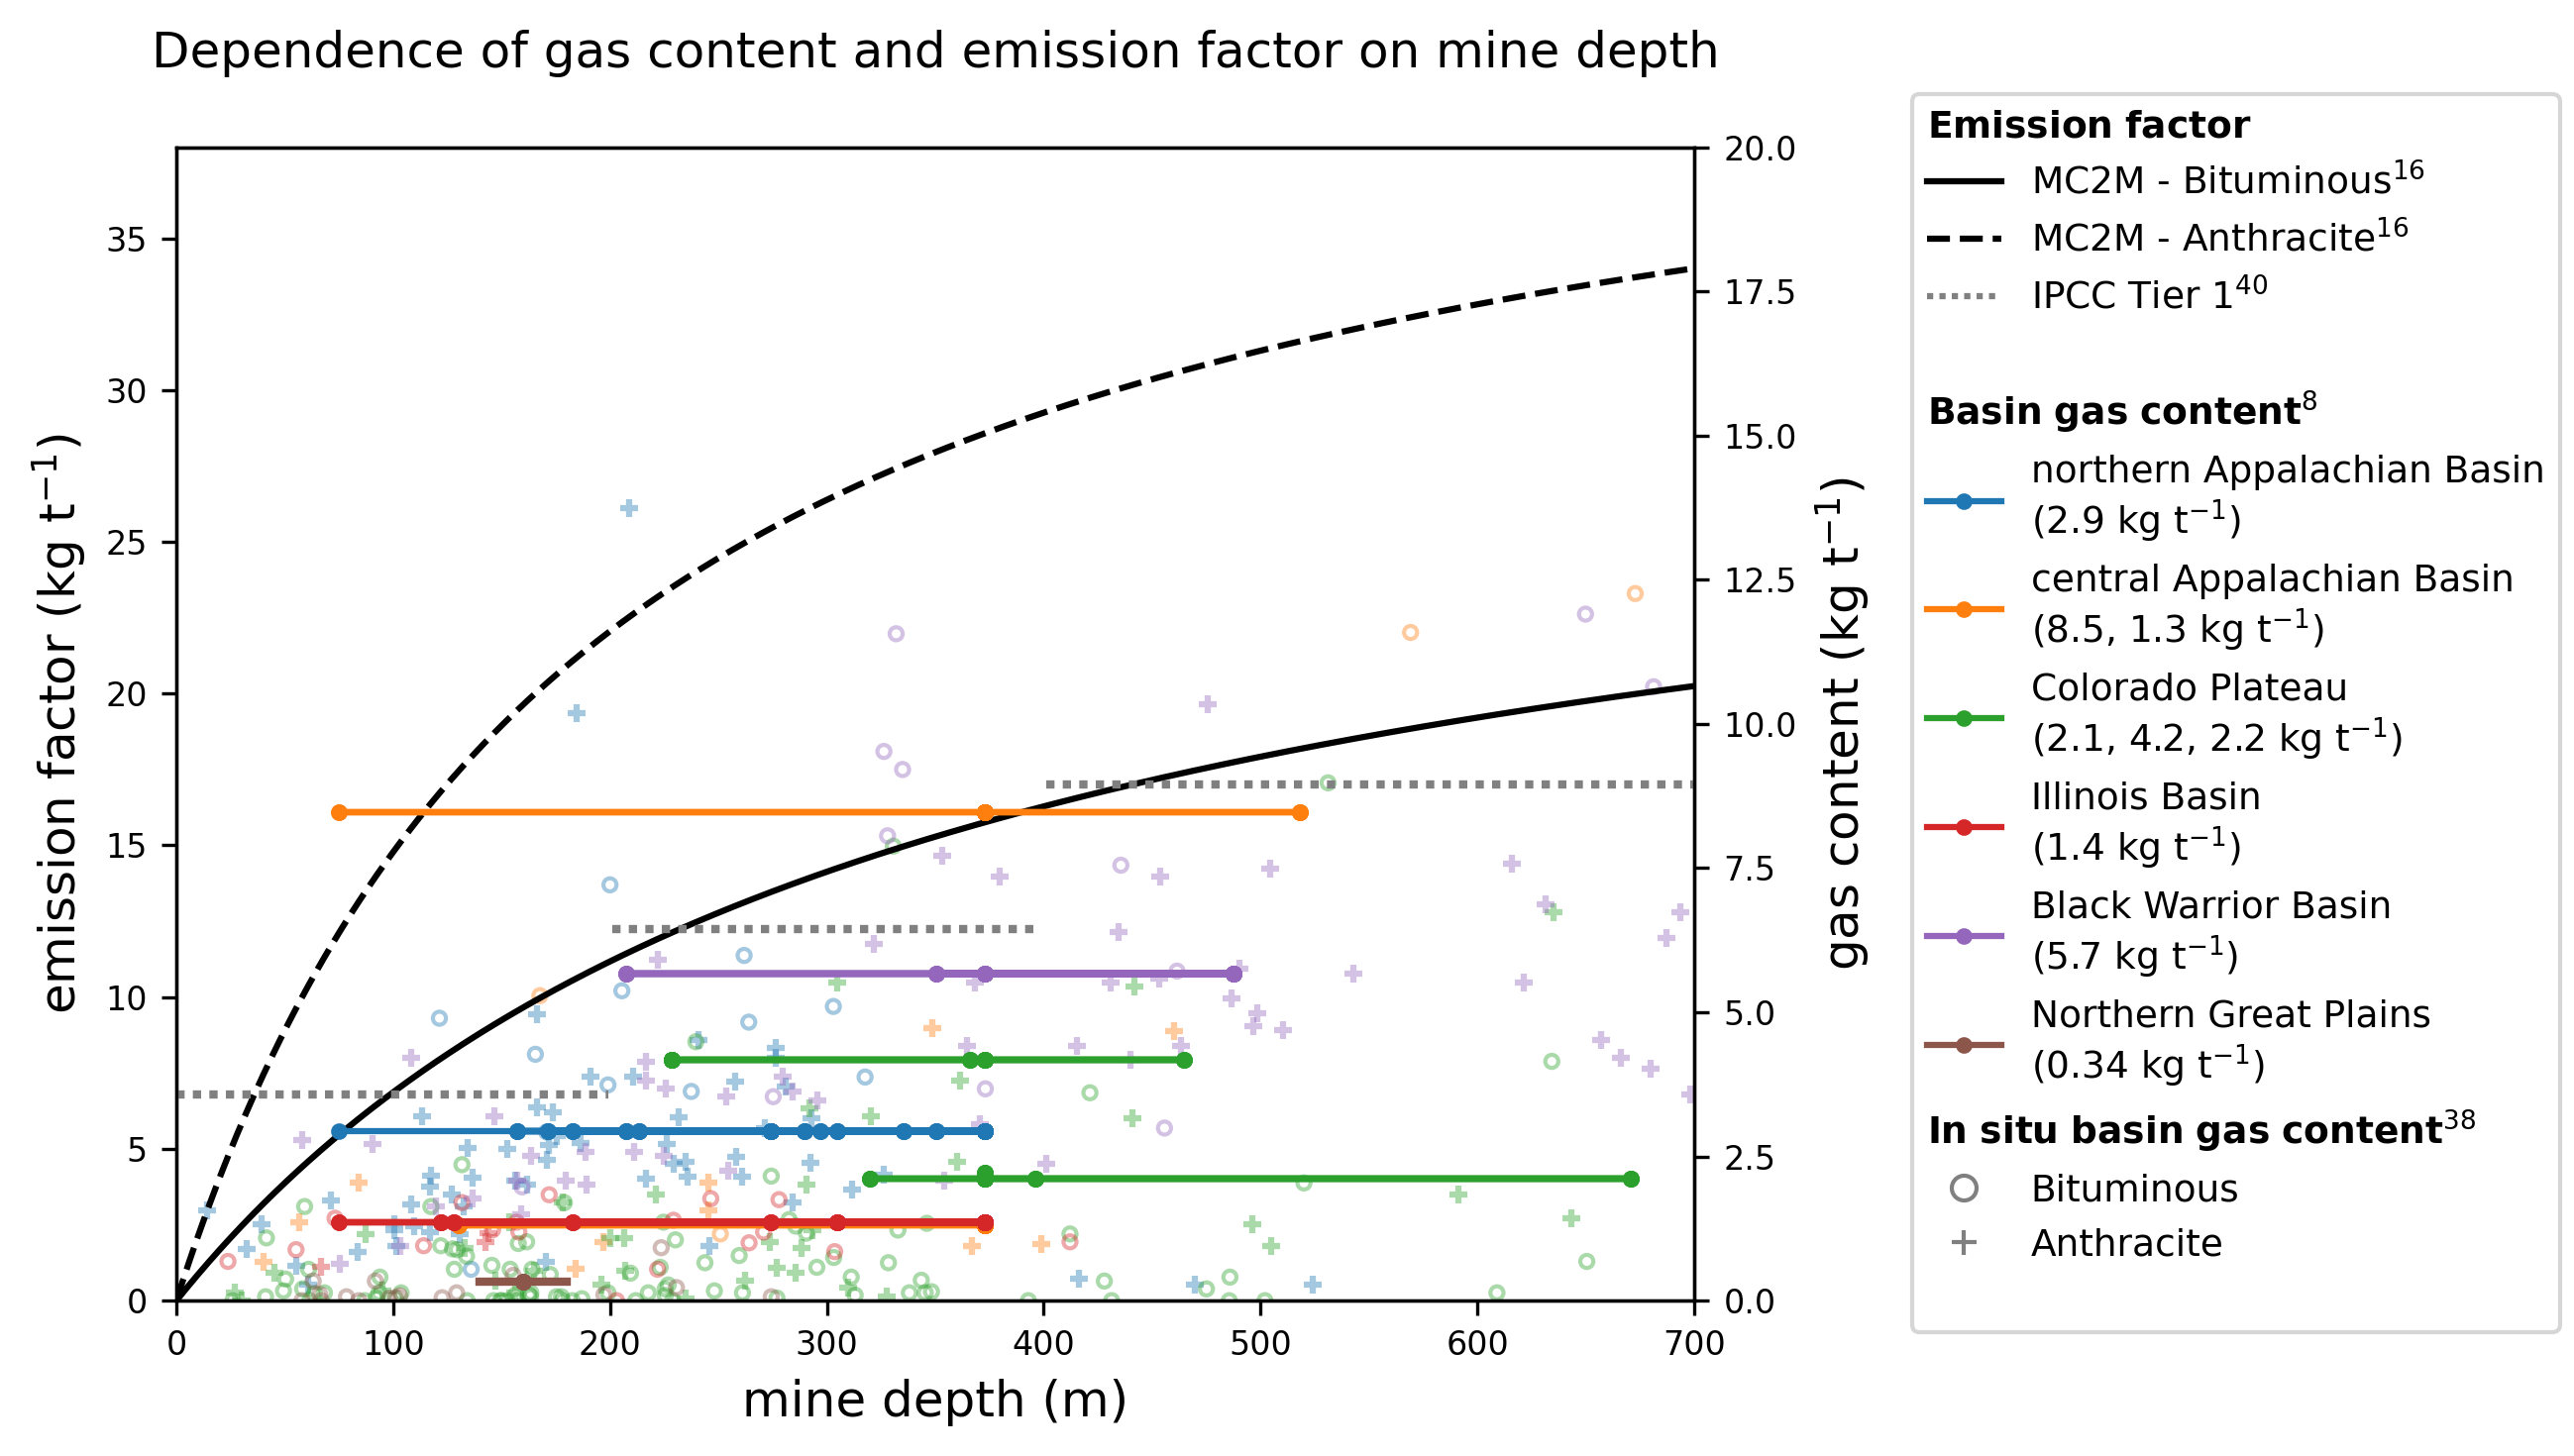

In [17]:

plt.rcParams.update({
    "axes.labelsize": 12,     # axis labels
    "axes.titlesize": 12,     # title
    "xtick.labelsize": 8,    # x-tick labels
    "ytick.labelsize": 8,    # y-tick labels
    "legend.fontsize": 9,     # legend font size (you are already controlling this manually)
})

legend_fontsize = 9
order=[2,0,3,1,4,5]
# all EFs are in M3/T - we convert them here to KG/T

# Create figure and **two** y-axes
fig, ax2 = plt.subplots(1,1, figsize=(6.5,5), dpi=300)
ax = ax2.twinx()  # second y-axis on the right side


# Plot MC2M lines on the **secondary** axis (ax2)

# BITUMINOUS
dummy_df = pd.DataFrame()
dummy_df["depth_m"] = np.arange(0,800,1.)
dummy_df["coal_grade"] = "Bituminous"
dummy_df = generate_MC2M_EFs(dummy_df, depth_col="depth_m", type_col="coal_grade", suffix="")
ax2.plot(dummy_df["depth_m"], dummy_df["Kholod_EF"] * M3_TO_KG, 
        label="MC2M predicted gas content\n(Kholod, 2020)", 
        color="k", linestyle="-", zorder=-1)

# ANTHRACITE
dummy_df = pd.DataFrame()
dummy_df["depth_m"] = np.arange(0,800,1.)
dummy_df["coal_grade"] = "Anthracite"
dummy_df = generate_MC2M_EFs(dummy_df, depth_col="depth_m", type_col="coal_grade", suffix="")
ax2.plot(dummy_df["depth_m"], dummy_df["Kholod_EF"] * M3_TO_KG, 
        label="MC2M predicted gas content\n(Kholod, 2020)",
        color="k", linestyle="--", zorder=-1)

# Plot IPCC Tier 1 line on (ax2)

dummy_df = pd.DataFrame()
dummy_df["depth_m"] = np.arange(0,800,1.)
dummy_df = generate_IPCC_EFs(dummy_df, depth_col="depth_m", suffix="")
# Insert NaN in IPCC_EF at exactly depth=200 and depth=400 to prevent vertical lines
dummy_df.loc[dummy_df["depth_m"] == 200, "IPCC_EF"] = np.nan
dummy_df.loc[dummy_df["depth_m"] == 400, "IPCC_EF"] = np.nan
ipcc_line = ax2.plot(dummy_df["depth_m"], dummy_df["IPCC_EF"] * M3_TO_KG, 
                     label="IPCC Tier 1", color="gray", linestyle=(0,(1,1)), linewidth=2, zorder=-1)

# Prepare combined mine depth
df["combined_mine_depth"] = df["Overburden"]
df.loc[df["combined_mine_depth"].isnull(),"combined_mine_depth"] = df.loc[df["combined_mine_depth"].isnull(),"Mine Depth (m)"]

# PLOT BY BASIN...
legend_contents3 = []
cmap = plt.get_cmap("tab10")

for i, basin in enumerate(df["Basin"].unique()[order]):
    if pd.isnull(basin):
        continue
    basin_color = cmap(i)
    if basin=="North Great Plains Basin": ngp_color = basin_color

    # PLOT GAS CONTENT (DIAMOND, ET AL) on the primary axis
    plot_df = grouped_df
    GAS_CONTENT = "TOTAL GAS (CM3/G)"
    DEPTH = "MEAN DEPTH (M)"
    COAL_TYPE = "RANK"

    subset = plot_df[(plot_df["Basin"] == basin) & (plot_df[COAL_TYPE] == "Bituminous")]
    if not subset.empty:
        p = ax.scatter(subset[DEPTH], subset[GAS_CONTENT] * M3_TO_KG, 
                       marker="o", facecolor="none", edgecolor=basin_color,
                       s=10, alpha=0.4, zorder=-5)

    subset = plot_df[(plot_df["Basin"] == basin) & (plot_df[COAL_TYPE] == "Anthracite")]
    if not subset.empty:
        ax.scatter(subset[DEPTH], subset[GAS_CONTENT] * M3_TO_KG,
                   marker="+", s=20, facecolor=basin_color, alpha=0.4, zorder=-5)

    # PLOT EMISSION FACTORS (as scatter) on the secondary axis
    plot_df = df
    GAS_CONTENT = "Basin_EF"
    DEPTH = "combined_mine_depth"
    COAL_TYPE = "Coal Type"

    for i, GC_value in enumerate(plot_df[GAS_CONTENT].unique()):
        subset = plot_df[(plot_df["Basin"] == basin)&(plot_df[GAS_CONTENT]==GC_value)].sort_values(by=GAS_CONTENT)
        if not subset.empty:
            ax2.plot(subset[DEPTH], subset[GAS_CONTENT] * M3_TO_KG, 
                   marker=".", color=basin_color, label=basin, zorder=10)
            
    gc_string = str(tuple((plot_df.loc[(plot_df["Basin"] == basin),GAS_CONTENT]*M3_TO_KG/1.9).apply(utils.format_sigfigs).unique()))
    print(f"{basin} EFs")
    print((plot_df.loc[(plot_df["Basin"] == basin),GAS_CONTENT]*M3_TO_KG).unique())
    print("kg / t")
    gc_string = gc_string.replace(",)", ")").replace(")", " $\mathrm{kg\ t^{-1}}$").replace("(", "").replace("'","")
    label = basin_names_replacement[basin] + "\n("+gc_string+")"
    legend_contents3.append((plt.Line2D([], [], marker='.', color=basin_color, linestyle='-'), label))

# Highlight North Great Plains point with a short horizontal dummy line
highlight_basin = "North Great Plains Basin"
highlight_df = df[df["Basin"] == highlight_basin]
highlight_val = highlight_df["Basin_EF"].values[0] * M3_TO_KG
highlight_depth = highlight_df["combined_mine_depth"].values[0]

# Create a short horizontal line (±5 m from actual depth)
ax2.plot([highlight_depth - 20, highlight_depth + 20], 
         [highlight_val, highlight_val],
         color=ngp_color, linewidth=2, zorder=10, label='_nolegend_')  # zorder to bring it on top


# ----------------------------------------------------------
# Build legends
# ----------------------------------------------------------

legend_contents1 = [
    (plt.Line2D([], [], linestyle='-',  marker=None, color='k'), "MC2M - Bituminous" + f"$^{{{KHOLOD2020}}}$"),
    (plt.Line2D([], [], linestyle='--', marker=None, color='k'), "MC2M - Anthracite" + f"$^{{{KHOLOD2020}}}$"),
    (mpl.lines.Line2D([], [], color='gray', linestyle=(0,(1,1))), "IPCC Tier 1" + f"$^{{{UNECE2022}}}$"),
    # (plt.Line2D([], [], marker='.', color='gray', linestyle='-'), "Basin-specific (EPA, 2024)"), 
    (Patch(visible=False), ''),  # spacer
]

legend_contents2 = [
    (plt.Line2D([], [], linestyle='', marker='o', markerfacecolor="none", markeredgecolor='gray'), 'Bituminous'),
    (plt.Line2D([], [], linestyle='', marker='+', markerfacecolor='none', markeredgecolor='gray'), 'Anthracite'),
    (Patch(visible=False), ''),  # spacer
]

legend_contents3 = legend_contents3  # from the scatter loop above


leg1 = mpl.legend.Legend(fig, *zip(*legend_contents1),
                         loc='center left', bbox_to_anchor=(0.98, .50),
                         fontsize=legend_fontsize,
                         title=r"$\bf{Emission\ factor}$"+"",
                         alignment='left')
leg2 = mpl.legend.Legend(fig, *zip(*legend_contents3),
                         loc='upper right', fontsize=legend_fontsize,
                         title=r"$\bf{Basin\ gas\ content}$" + f"$^{{{EPA2024}}}$")
leg3 = mpl.legend.Legend(fig, *zip(*legend_contents2),
                         loc='center left', fontsize=legend_fontsize,
                         title = r"$\bf{In\ situ\ basin\ gas\ content}$" + f"$^{{{DIAMOND1986}}}$"
,
                         alignment='left')

def append_legends(legend_list, fig):
    """
    Merge multiple Legend objects in one figure.
    """
    base_legend = legend_list[0]
    for legend in legend_list[1:]:
        base_legend_box = base_legend.get_children()[0]
        this_legend_box = legend.get_children()[0]
        base_legend_box.get_children().extend(this_legend_box.get_children())
    fig.legends.append(base_legend)

legend_list = [leg1, leg2, leg3, ]
[l.get_title().set_fontsize(legend_fontsize) for l in legend_list]
append_legends(legend_list, fig)

# Final labeling
ax.set_title("Dependence of gas content and emission factor on mine depth\n")
ax.set_xlabel("mine depth (m)")
ax.set_ylabel("gas content ($\mathrm{kg\ t^{-1}}$)")
ax2.set_ylabel("emission factor ($\mathrm{kg\ t^{-1}}$)") 
ax2.set_xlabel("mine depth (m)") 
ax.set_xlim(0, 700)
ax.set_ylim(0,20)
ax2.set_ylim(0,20*1.9) # C_EF = 1.9

# Ensure basin gas contents plot on top
ax2.set_zorder(ax.get_zorder() + 1)
ax2.patch.set_visible(False)

plt.tight_layout()
plt.savefig('./figures/figure_3.png', bbox_inches='tight')
plt.show()

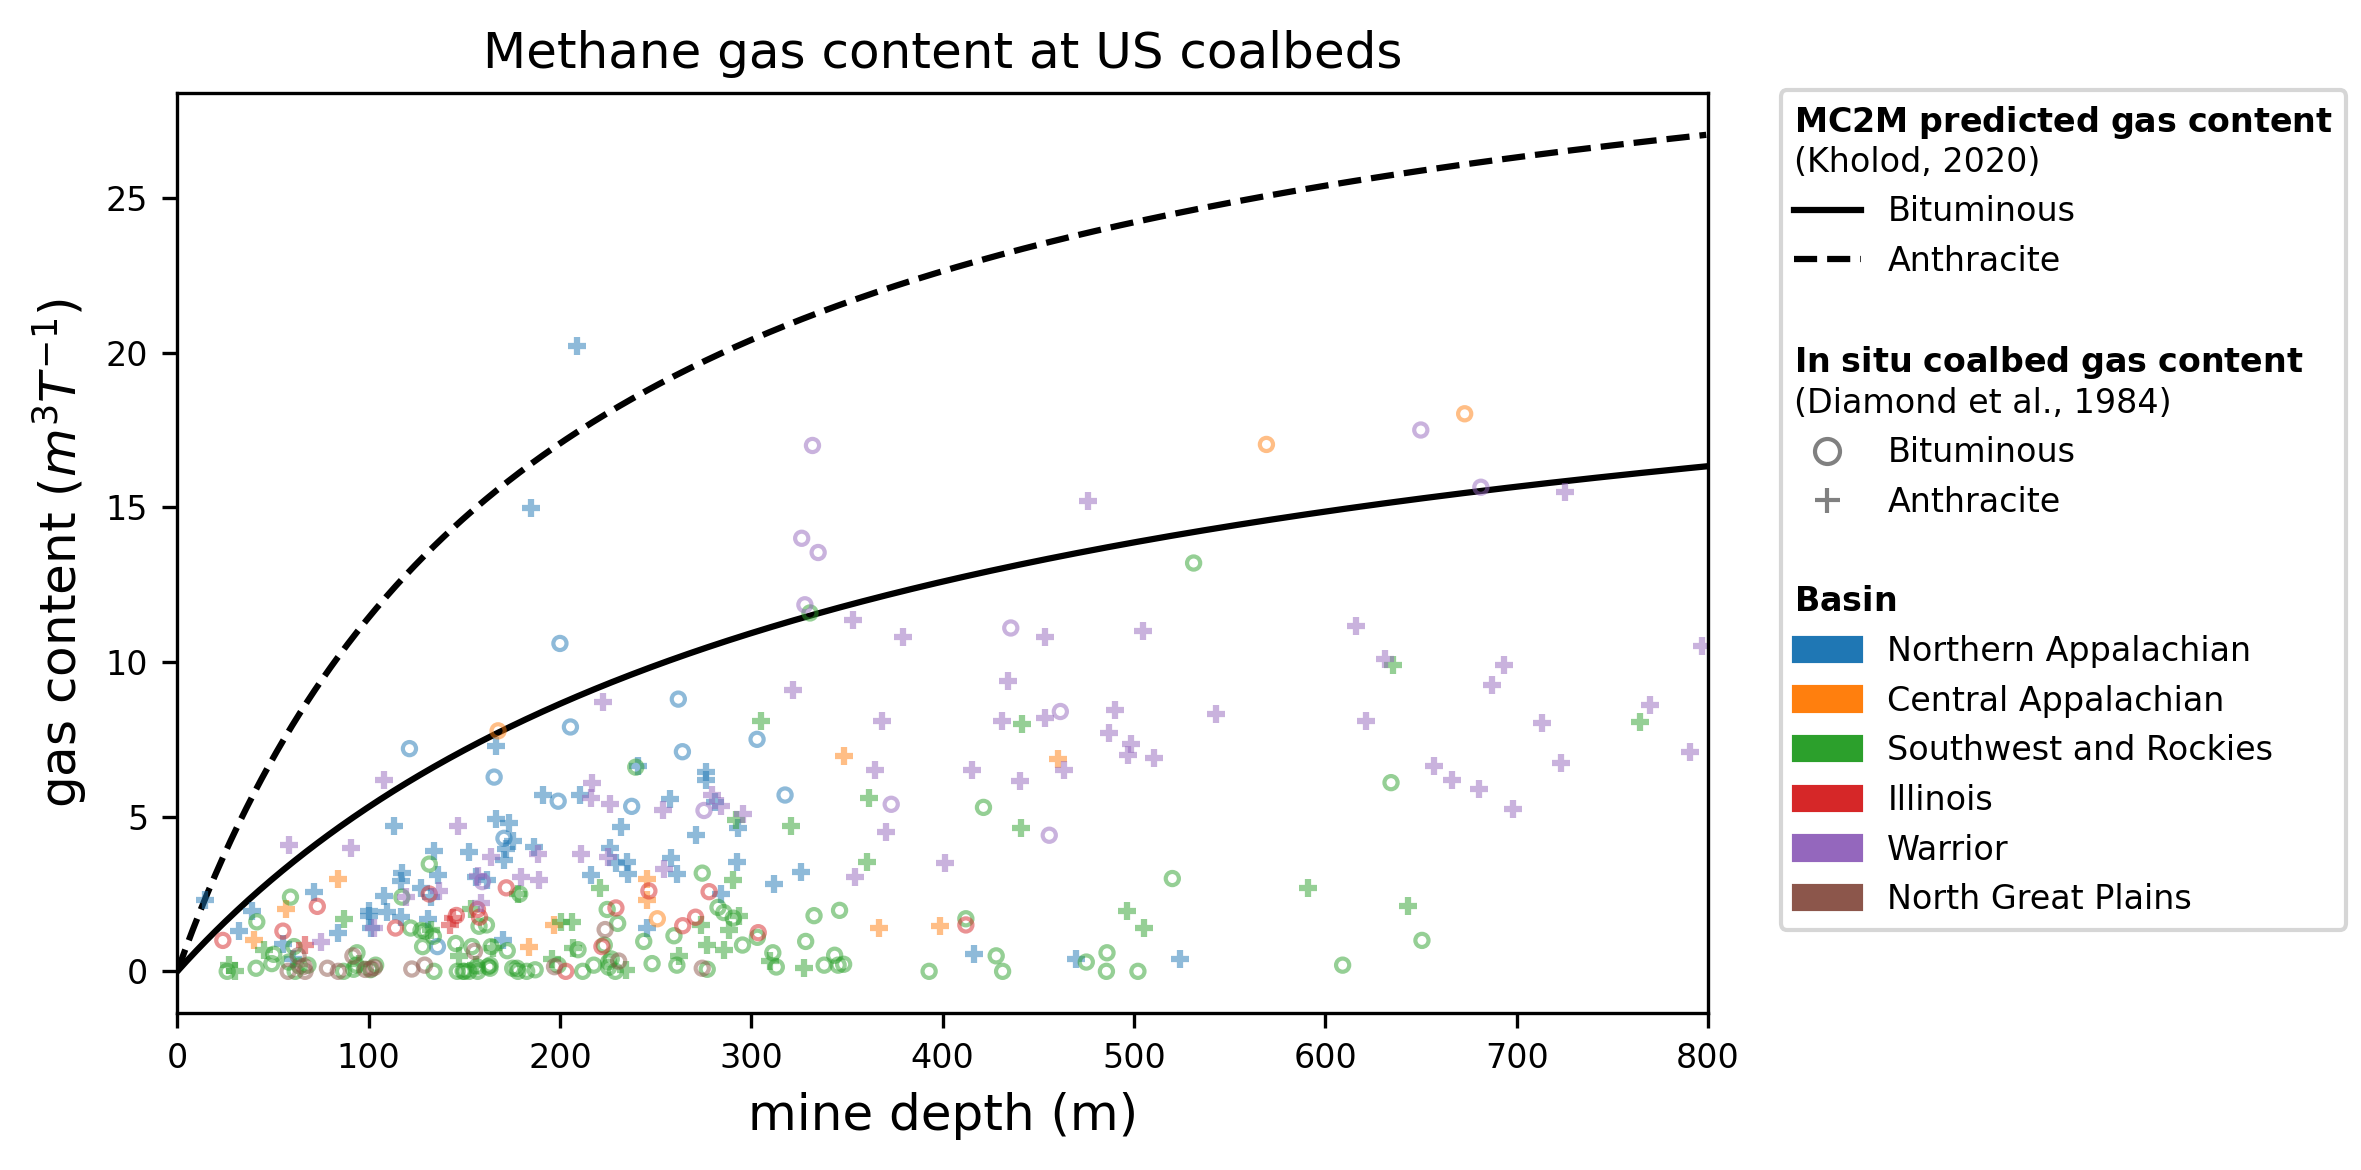

In [18]:
fig = plt.figure(figsize=(6,4), dpi=300)
legend_fontsize = 8
order=[3,0,5,1,6,2] # order of legend

# dummy DF of MC2M
dummy_df = pd.DataFrame()
dummy_df['depth_m'] = np.arange(0,800,1.)
dummy_df['coal_grade'] = 'Bituminous'
dummy_df = generate_MC2M_EFs(dummy_df, depth_col="depth_m", type_col="coal_grade", suffix="")
plt.plot(dummy_df.depth_m, dummy_df.MC2M_gas_content, label="MC2M predicted gas content\n(Kholod, 2020)", color='k', zorder=-1)


# dummy DF of MC2M
dummy_df = pd.DataFrame()
dummy_df['depth_m'] = np.arange(0,800,1.)
dummy_df['coal_grade'] = 'Anthracite'
dummy_df = generate_MC2M_EFs(dummy_df, depth_col="depth_m", type_col="coal_grade", suffix="")
plt.plot(dummy_df.depth_m, dummy_df.MC2M_gas_content, label="MC2M predicted gas content\n(Kholod, 2020)", color='k', linestyle='--', zorder=-1)

# settings for gas content DF
plot_df = grouped_df
GAS_CONTENT = 'TOTAL GAS (CM3/G)'
DEPTH = 'MEAN DEPTH (M)'
COAL_TYPE = 'RANK'
GC_CONVERSION = 1. #FT3_PER_SHORT_TON_TO_M3_PER_TON


legend_contents3 = []
cmap = plt.get_cmap("tab10")
for i,basin in enumerate(plot_df['Basin'].unique()[order]):
    if pd.isnull(basin):
        continue
    subset =plot_df[(plot_df['Basin'] == basin)&(plot_df[COAL_TYPE]=='Bituminous')]
    if subset.empty: continue
    basin_color = cmap(i)
    p = plt.scatter(subset[DEPTH], subset[GAS_CONTENT] * GC_CONVERSION, marker="o", 
                    facecolor='none', edgecolor=basin_color, s=10, alpha=0.5)
    legend_contents3.append((Patch(color=basin_color), basin.replace(' Basin','')))
    
    subset =plot_df[(plot_df['Basin'] == basin)&(plot_df[COAL_TYPE]=='Anthracite')]
    if subset.empty: continue
    plt.scatter(subset[DEPTH], subset[GAS_CONTENT] * GC_CONVERSION, 
                marker="+", s=20, facecolor=basin_color, alpha=0.5)

legend_contents1 = [
    (plt.Line2D([], [], linestyle='-', marker=None, color='k'), "Bituminous"),
    (plt.Line2D([], [], linestyle='--', marker=None, color='k'), "Anthracite"),
    (Patch(visible=False), ''),  # spacer
    ] 

legend_contents2 = [
    (plt.Line2D([], [], linestyle='', marker='o', markerfacecolor="none", markeredgecolor='gray'), 'Bituminous'),
    (plt.Line2D([], [], linestyle='', marker='+', markerfacecolor='none', markeredgecolor='gray'), 'Anthracite'),
    (Patch(visible=False), ''),  # spacer
    ] 

def append_legends(legend_list, fig):
    """
    Sources: 
    - https://stackoverflow.com/questions/24787041/multiple-titles-in-legend-in-matplotlib
    - https://github.com/mwaskom/seaborn/blob/v0.12/seaborn/_core/plot.py#L1620-L1640
    """
    base_legend = legend_list[0]
    for legend in legend_list[1:]:
        base_legend_box = base_legend.get_children()[0]
        this_legend_box = legend.get_children()[0]
        base_legend_box.get_children().extend(this_legend_box.get_children())
    fig.legends.append(base_legend)
    

plt.title("Methane gas content at US coalbeds")
ax = plt.gca()
plt.xlabel("mine depth (m)")
plt.ylabel("gas content ($m^3 T ^{-1}$)")
leg1 = mpl.legend.Legend(fig,*zip(*legend_contents1), loc='center left', bbox_to_anchor=(0.98, .55), fontsize=legend_fontsize, 
                         title=r"$\bf{MC2M\ predicted\ gas\ content}$" +"\n(Kholod, 2020)", alignment='left')
leg2 = mpl.legend.Legend(fig,*zip(*legend_contents2), loc='center left', fontsize=legend_fontsize, 
                         title=r"$\bf{In\ situ\ coalbed\ gas\ content}$"+"\n(Diamond et al., 1984)", alignment='left')
leg3 = mpl.legend.Legend(fig,*zip(*legend_contents3), loc='upper right', fontsize=legend_fontsize, title=r'$\bf{Basin}$')
legend_list = [leg1, leg2, leg3]
[l.get_title().set_fontsize(legend_fontsize) for l in legend_list]
append_legends(legend_list, fig)
plt.xlim(0,800)
plt.tight_layout()
plt.show()

In [19]:
basin_gas_content[["ST", "Basin", "Underground Average In Situ Content (ft3/short ton)"]]

,ST,Basin,Underground Average In Situ Content (ft3/short ton)
0,KY,Central Appalachian Basin,61.4
1,TN,Central Appalachian Basin,61.4
2,VA,Central Appalachian Basin,399.1
4,IL,Illinois Basin,64.3
5,IN,Illinois Basin,64.3
7,MT,North Great Plains Basin,15.8
8,ND,North Great Plains Basin,15.8
9,WY,North Great Plains Basin,15.8
10,MD,Northern Appalachian Basin,138.4
11,OH,Northern Appalachian Basin,138.4


In [20]:
annual_df[annual_df.Kholod_emis_CoalAge_M_T==0]

,,GEM_emis_M_T,Kholod_emis_M_T,IPCC_emis_M_T,GEM_emis_CoalAge_M_T,Kholod_emis_CoalAge_M_T,IPCC_emis_CoalAge_M_T,Basin_emis_M_T,replicate_GEM_emis_M_T,GEM Coal Mine Methane Emissions Estimate (M tonnes/yr)
Mine Name,CAL_YR,,,,,,,,,


Text(0, 0.5, 'GEM EF')

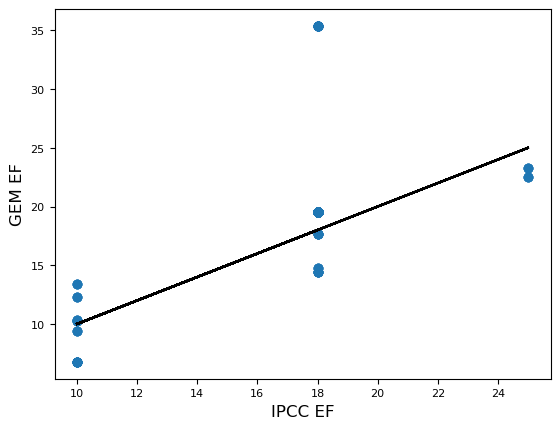

In [21]:
plt.plot(df['IPCC_EF'], df['GEM_EF'], 'o')
plt.plot(df['IPCC_EF'], df['IPCC_EF'], 'k')
plt.xlabel("IPCC EF")
plt.ylabel("GEM EF")